# Extract Safran Data


In [109]:
# Magic
%load_ext autoreload
%autoreload 2

# Imports

from tqdm import tqdm

import netCDF4 as nc
import rasterio
import xarray as xr

import pandas as pd
import glob
import numpy as np
import os
import folium
import matplotlib.pyplot as plt
import chime
import datetime as datetime
from datetime import datetime

chime.theme("mario")

# Import Functions
import sys

sys.path.insert(0, "../../src")
from run_mp import *
from utilities import *
from gee_data_wrangling import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# StackOverflow Example


In [224]:
lats = np.array(
    [
        [21.138, 21.14499, 21.15197, 21.15894, 21.16591],
        [21.16287, 21.16986, 21.17684, 21.18382, 21.19079],
        [21.18775, 21.19474, 21.20172, 21.2087, 21.21568],
        [21.21262, 21.21962, 21.22661, 21.23359, 21.24056],
        [21.2375, 21.2445, 21.25149, 21.25848, 21.26545],
    ]
)

lons = np.array(
    [
        [-122.72, -122.69333, -122.66666, -122.63999, -122.61331],
        [-122.7275, -122.70082, -122.67415, -122.64746, -122.62078],
        [-122.735, -122.70832, -122.68163, -122.65494, -122.62825],
        [-122.7425, -122.71582, -122.68912, -122.66243, -122.63573],
        [-122.75001, -122.72332, -122.69662, -122.66992, -122.64321],
    ]
)

speed = np.array(
    [
        [10.934007, 10.941321, 10.991583, 11.063932, 11.159435],
        [10.98778, 10.975482, 10.990983, 11.042522, 11.131154],
        [11.013505, 11.001573, 10.997754, 11.03566, 11.123781],
        [11.011163, 11.000227, 11.010223, 11.049, 11.1449],
        [11.015698, 11.026604, 11.030653, 11.076904, 11.201464],
    ]
)

dsex = xr.Dataset(
    {"SPEED": (("x", "y"), speed)},
    coords={"latitude": (("x", "y"), lats), "longitude": (("x", "y"), lons)},
    attrs={"variable": "Wind Speed"},
)

In [225]:
dsex

<xarray.Dataset>
Dimensions:    (x: 5, y: 5)
Coordinates:
    latitude   (x, y) float64 21.14 21.14 21.15 21.16 ... 21.25 21.26 21.27
    longitude  (x, y) float64 -122.7 -122.7 -122.7 ... -122.7 -122.7 -122.6
Dimensions without coordinates: x, y
Data variables:
    SPEED      (x, y) float64 10.93 10.94 10.99 11.06 ... 11.03 11.03 11.08 11.2
Attributes:
    variable:  Wind Speed

<xarray.DataArray 'longitude' (x: 5, y: 5)>
array([[0.092  , 0.08501, 0.07803, 0.07106, 0.09669],
       [0.06713, 0.06014, 0.05316, 0.06254, 0.08922],
       [0.04225, 0.03526, 0.02837, 0.05506, 0.08175],
       [0.0325 , 0.01038, 0.02088, 0.04757, 0.07427],
       [0.04001, 0.0145 , 0.02149, 0.04008, 0.06679]])
Coordinates:
    latitude   (x, y) float64 21.14 21.14 21.15 21.16 ... 21.25 21.26 21.27
    longitude  (x, y) float64 -122.7 -122.7 -122.7 ... -122.7 -122.7 -122.6
Dimensions without coordinates: x, y


Text(0.5, 1.0, 'speed at nearest point: 11.000227')

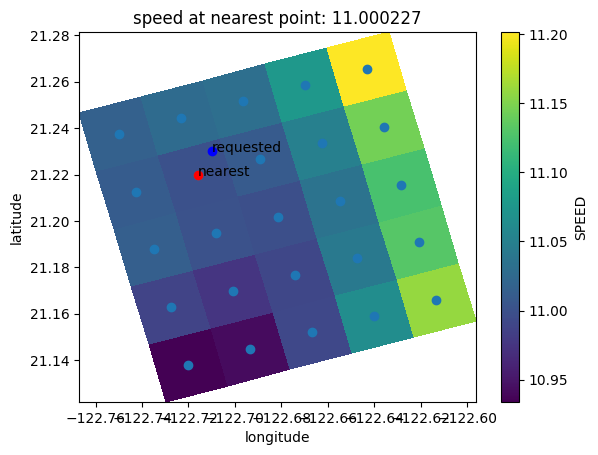

In [312]:
# A 2D plot of the SPEED variable, assigning the coordinate values,
# and plot the verticies of each point
dsex.SPEED.plot(x="longitude", y="latitude")
plt.scatter(dsex.longitude, dsex.latitude)

# I want to find the speed at a certain lat/lon point.
lat = 21.23
lon = -122.71

# First, find the index of the grid point nearest a specific lat/lon.
abslat = np.abs(dsex.latitude - lat)
abslon = np.abs(dsex.longitude - lon)
c = np.maximum(abslon, abslat)
print(c)
([xloc], [yloc]) = np.where(c == np.min(c))

# Now I can use that index location to get the values at the x/y diminsion
point_dsex = dsex.sel(x=xloc, y=yloc)

# Plot requested lat/lon point blue
plt.scatter(lon, lat, color="b")
plt.text(lon, lat, "requested")

# Plot nearest point in the array red
plt.scatter(point_dsex.longitude, point_dsex.latitude, color="r")
plt.text(point_dsex.longitude, point_dsex.latitude, "nearest")

plt.title("speed at nearest point: %s" % point_dsex.SPEED.data)

# 👉 User Input


In [107]:
# Give list of ncfiles
ffolder = "../../data/raw/safran/"
ffolder = glob.glob(ffolder + "*.nc")

# Remove path from folder
ffolder_noprefix = sorted([os.path.basename(x) for x in ffolder])

print("Datasets available for extraction:")
for i, f in enumerate(ffolder):
    print(f" {i+1}.\t{f}")

Datasets available for extraction:
 1.	../../data/raw/safran/ORCHIDEE_France-8km-1hour_2000_fromSAFRAN.nc
 2.	../../data/raw/safran/ORCHIDEE_France-8km-1hour_2001_fromSAFRAN.nc
 3.	../../data/raw/safran/ORCHIDEE_France-8km-1hour_2002_fromSAFRAN.nc


# Load one NC file for checking


In [227]:
ds = xr.open_dataset(ffolder[0])
display(ds)
display("---")
print(ds.get_index("lat"))
print(ds.get_index("lon"))
print(ds.get_index("tstep"))

<xarray.Dataset>
Dimensions:  (tstep: 8784, lat: 134, lon: 143)
Coordinates:
    lat      (lat, lon) float32 ...
    lon      (lat, lon) float32 ...
  * tstep    (tstep) datetime64[ns] 2000-01-01 ... 2000-12-31T23:00:00
Data variables:
    Qair     (tstep, lat, lon) float32 ...
    Tair     (tstep, lat, lon) float32 ...
    Wind     (tstep, lat, lon) float32 ...
    Rainf    (tstep, lat, lon) float64 ...
    Snowf    (tstep, lat, lon) float64 ...
    SWdown   (tstep, lat, lon) float32 ...
    LWdown   (tstep, lat, lon) float32 ...
    PSurf    (tstep, lat, lon) float32 ...
Attributes:
    history:                    Sat Sep 10 23:33:30 2022: ncks -v tstep Times...
    history_of_appended_files:  Sat Sep 10 23:33:30 2022: Appended file Times...
    NCO:                        "4.6.3"

'---'

RangeIndex(start=0, stop=134, step=1, name='lat')
RangeIndex(start=0, stop=143, step=1, name='lon')
DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 01:00:00',
               '2000-01-01 02:00:00', '2000-01-01 03:00:00',
               '2000-01-01 04:00:00', '2000-01-01 05:00:00',
               '2000-01-01 06:00:00', '2000-01-01 07:00:00',
               '2000-01-01 08:00:00', '2000-01-01 09:00:00',
               ...
               '2000-12-31 14:00:00', '2000-12-31 15:00:00',
               '2000-12-31 16:00:00', '2000-12-31 17:00:00',
               '2000-12-31 18:00:00', '2000-12-31 19:00:00',
               '2000-12-31 20:00:00', '2000-12-31 21:00:00',
               '2000-12-31 22:00:00', '2000-12-31 23:00:00'],
              dtype='datetime64[ns]', name='tstep', length=8784, freq=None)


In [417]:
ds_var_tstep[1, 1]

<xarray.DataArray 'Qair' ()>
[1 values with dtype=float32]
Coordinates:
    lat      float32 41.44
    lon      float32 -4.009
    tstep    datetime64[ns] 2000-01-01
Attributes:
    units:          kg/kg
    long_name:      near-surface 2m specific humidity
    standard_name:  specific_humidity
    original_name:  Qair
    grid_mapping:   Lambert_conformal
    actual_range:   [9.45773771e-05 2.95138582e-02]
    valid_range:    [0. 1.]

In [458]:
def safran_extract_value(ds_in, lat_in, lon_in, return_fig=False):
    """
    Extracts a value from a safran netcdf dataset (subsetted to variable AND time) at a given lat/lon point.
    """

    # First, find the index of the grid point nearest the inputted lat/lon.
    abslat = np.abs(ds_in.lat - lat_in)
    abslon = np.abs(ds_in.lon - lon_in)
    c = np.maximum(abslon, abslat)
    ([latloc], [lonloc]) = np.where(c == np.min(c))

    # Now I can use that index location to get the values at the x/y diminsion
    point_ds = ds_in.isel(lon=lonloc, lat=latloc)

    if return_fig:
        # Make plot with two figures side by side
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        # Plot for full France
        # axs[0].scatter(ds_in.lon, ds_in.lat)
        ds_in.plot(x="lon", y="lat", ax=axs[0])
        # Plot requested lat/lon point blue
        axs[0].scatter(lon_in, lat_in, color="b")
        axs[0].text(lon_in, lat_in, "requested")
        # Plot nearest point in the array red
        axs[0].scatter(point_ds.lon, point_ds.lat, color="r")
        axs[0].text(point_ds.lon, point_ds.lat, "nearest")
        axs[0].set_title("Value at nearest point: %s" % point_ds.data)

        # Plot zoomed into extracted point
        # Plot grid around extracted poin
        ds_sub = ds_in[latloc - 4 : latloc + 4, lonloc - 4 : lonloc + 4]
        ds_sub.plot(x="lon", y="lat", ax=axs[1])
        axs[1].scatter(ds_sub.lon, ds_sub.lat, color="white")
        # Plot requested lat/lon point blue
        axs[1].scatter(lon_in, lat_in, color="b")
        axs[1].text(lon_in, lat_in, "requested")
        # Plot nearest point in the array red
        axs[1].scatter(point_ds.lon, point_ds.lat, color="r")
        axs[1].text(point_ds.lon, point_ds.lat, "nearest")
        axs[1].set_title("Value at nearest point: %s" % point_ds.data)

    return point_ds.data.item()


safran_extract_value(
    ds_in=xr.open_dataset(ffolder[0])["Tair"][0, :, :],
    lat_in=47.067897,
    lon_in=2.197266,
    return_fig=False,
)

280.3518981933594

In [485]:
def safran_get_closest_point(ds_in, lat_in, lon_in):
    """
    Extracts a value from a safran netcdf dataset (subsetted to variable AND time) at a given lat/lon point.
    """

    # First, find the index of the grid point nearest the inputted lat/lon.
    abslat = np.abs(ds_in.lat - lat_in)
    abslon = np.abs(ds_in.lon - lon_in)
    c = np.maximum(abslon, abslat)
    ([latloc], [lonloc]) = np.where(c == np.min(c))

    return latloc, lonloc


safran_get_closest_point(
    ds_in=xr.open_dataset(ffolder[0])["SWdown"][0, :, :],
    lat_in=47.067897,
    lon_in=2.197266,
)

(77, 66)

In [493]:
def safran_extract_from_index(ds_in, latloc, lonloc):
    """
    Extracts a value from a safran netcdf dataset (subsetted to variable AND time) at a given lat/lon point.
    """

    # Now I can use that index location to get the values at the x/y diminsion
    point_ds = ds_in.isel(lon=lonloc, lat=latloc)

    return point_ds.data.item()


plat, plon = safran_get_closest_point(
    ds_in=xr.open_dataset(ffolder[0]),
    lat_in=47.067897,
    lon_in=2.197266,
)

safran_extract_from_index(
    ds_in=xr.open_dataset(ffolder[0])["Tair"][0, :, :],
    latloc=plat,
    lonloc=plon,
)

280.3518981933594

In [500]:
ds_test = ds_org

<xarray.DataArray 'Qair' (tstep: 8784, lat: 134, lon: 143)>
[168319008 values with dtype=float32]
Coordinates:
    lat      (lat, lon) float32 41.36 41.37 41.37 41.38 ... 50.85 50.84 50.83
    lon      (lat, lon) float32 -4.096 -4.001 -3.907 ... 10.57 10.68 10.79
  * tstep    (tstep) datetime64[ns] 2000-01-01 ... 2000-12-31T23:00:00
Attributes:
    units:          kg/kg
    long_name:      near-surface 2m specific humidity
    standard_name:  specific_humidity
    original_name:  Qair
    grid_mapping:   Lambert_conformal
    actual_range:   [9.45773771e-05 2.95138582e-02]
    valid_range:    [0. 1.]

<xarray.DataArray 'PSurf' (lat: 10, lon: 10)>
[100 values with dtype=float32]
Coordinates:
    lat      (lat, lon) float32 46.59 46.59 46.59 46.59 ... 47.24 47.24 47.24
    lon      (lat, lon) float32 1.554 1.659 1.763 1.867 ... 2.284 2.39 2.496
    tstep    datetime64[ns] 2000-01-01T01:00:00
Attributes:
    long_name:        Pression
    units:            Pa
    min_valid_range:  70000
    max_valid_range:  101500

([66], [77])


Text(0.5, 1.0, 'Value at nearest point: [99841.07 99841.07 99841.07 ... 99841.07 99841.07 99841.07]')

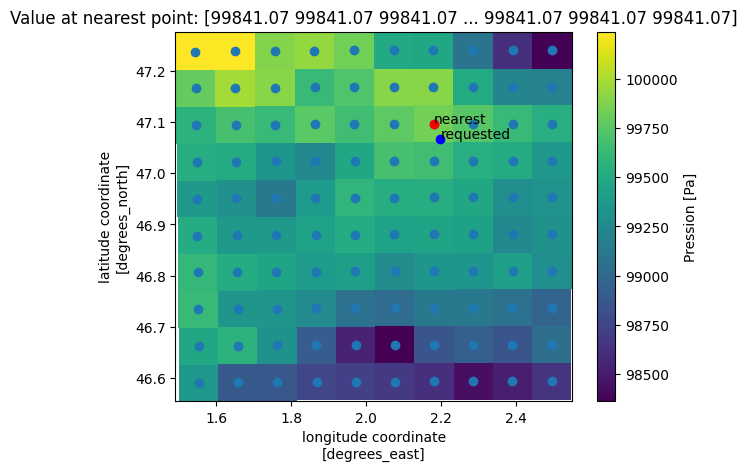

In [341]:
# dss = ds.Tair[1, 50:60, 50:60]  # Taking a subset of tstep, lat, lon
dss = ds.PSurf[1, 70:80, 60:70]  # Taking a subset of tstep, lat, lon
dss.plot(x="lon", y="lat")
display(dss)
plt.scatter(dss.lon, dss.lat)
mylat = 47.067897
mylon = 2.197266

abslat = np.abs(ds.lat - mylat)
abslon = np.abs(ds.lon - mylon)
c = np.maximum(abslat, abslon)
([latloc], [lonloc]) = np.where(c == np.min(c))
print(([lonloc], [latloc]))
point_dss = ds.PSurf.isel(lon=lonloc, lat=latloc)

plt.scatter(mylon, mylat, color="b")
plt.text(mylon, mylat, "requested")

# Plot nearest point in the array red
plt.scatter(point_dss.lon, point_dss.lat, color="r")
plt.text(point_dss.lon, point_dss.lat, "nearest")

plt.title("Value at nearest point: %s" % point_dss.data)

In [494]:
# WIP ---------------------------------------------------------------
# Load dataset
nc_file = ffolder[0]
ds_org = xr.open_dataset(nc_file)

# Get all variables and timesteps
all_vars = list(ds_org.variables.keys())
all_vars.remove("lon")
all_vars.remove("lat")
all_vars.remove("tstep")
all_tsteps = ds_org.get_index("tstep").to_list()

# Loop over coordinates
lats = [47.067897, 48, 47.5]
lons = [2.197266, 2.5, 2.3]

df_out = pd.DataFrame(columns=["lat", "lon", "tstep", "variable", "value"])

for lat, lon in zip(lats, lons):
    print(f" - Working on coordinate: {lats.index(lat)+1}/{len(lats)}")
    # Get closes point
    latloc, lonloc = safran_get_closest_point(ds_org, lat, lon)

    # Loop over variables
    for my_var in all_vars:
        # Get ds based on current variable
        # Print index of var as counter for progress
        print(f"    - Working on variable: {all_vars.index(my_var)+1}/{len(all_vars)}")
        # print(my_var)
        ds_var = ds_org[my_var]

        # Loop through all timesteps)
        for i in tqdm(range(len(all_tsteps)), desc="        - Working on hour: "):
            # Get ds based on current timestep
            # print(f" .{i}\t {all_tsteps[i]}")
            ds_var_tstep = ds_var[i, :, :]
            # safran_extract_value(ds_var_tstep, lat, lon, return_fig=True)

            df_i = pd.DataFrame(
                {
                    "lat": [lat],
                    "lon": [lon],
                    "tstep": [all_tsteps[i]],
                    "variable": [my_var],
                    # "value": [safran_extract_value(ds_var_tstep, lat, lon)],
                    "value": [safran_extract_from_index(ds_var_tstep, latloc, lonloc)],
                }
            )

            df_out = pd.concat([df_out, df_i], axis=0)

    # Get ds based on current timestep
    # ds_var_tstep = ds_var[my_tstep]

 - Working on coordinate: 1/3
    - Working on variable: 1/8


        - Working on hour: 100%|██████████| 8784/8784 [00:07<00:00, 1139.21it/s]


    - Working on variable: 2/8


        - Working on hour: 100%|██████████| 8784/8784 [00:07<00:00, 1153.60it/s]


    - Working on variable: 3/8


        - Working on hour: 100%|██████████| 8784/8784 [00:09<00:00, 970.60it/s] 


    - Working on variable: 4/8


        - Working on hour: 100%|██████████| 8784/8784 [00:09<00:00, 911.99it/s]


    - Working on variable: 5/8


        - Working on hour: 100%|██████████| 8784/8784 [00:10<00:00, 852.82it/s]


    - Working on variable: 6/8


        - Working on hour: 100%|██████████| 8784/8784 [00:10<00:00, 806.55it/s]


    - Working on variable: 7/8


        - Working on hour: 100%|██████████| 8784/8784 [00:11<00:00, 749.92it/s]


    - Working on variable: 8/8


        - Working on hour: 100%|██████████| 8784/8784 [00:11<00:00, 750.54it/s]


 - Working on coordinate: 2/3
    - Working on variable: 1/8


        - Working on hour: 100%|██████████| 8784/8784 [00:13<00:00, 642.13it/s]


    - Working on variable: 2/8


        - Working on hour: 100%|██████████| 8784/8784 [00:14<00:00, 618.85it/s]


    - Working on variable: 3/8


        - Working on hour: 100%|██████████| 8784/8784 [00:14<00:00, 596.99it/s]


    - Working on variable: 4/8


        - Working on hour: 100%|██████████| 8784/8784 [00:15<00:00, 554.42it/s]


    - Working on variable: 5/8


        - Working on hour: 100%|██████████| 8784/8784 [00:16<00:00, 548.24it/s]


    - Working on variable: 6/8


        - Working on hour: 100%|██████████| 8784/8784 [00:16<00:00, 529.48it/s]


    - Working on variable: 7/8


        - Working on hour: 100%|██████████| 8784/8784 [00:17<00:00, 512.73it/s]


    - Working on variable: 8/8


        - Working on hour: 100%|██████████| 8784/8784 [00:17<00:00, 514.90it/s]


 - Working on coordinate: 3/3
    - Working on variable: 1/8


        - Working on hour: 100%|██████████| 8784/8784 [00:18<00:00, 474.49it/s]


    - Working on variable: 2/8


        - Working on hour: 100%|██████████| 8784/8784 [00:19<00:00, 456.69it/s]


    - Working on variable: 3/8


        - Working on hour: 100%|██████████| 8784/8784 [00:19<00:00, 445.02it/s]


    - Working on variable: 4/8


        - Working on hour: 100%|██████████| 8784/8784 [00:21<00:00, 414.61it/s]


    - Working on variable: 5/8


        - Working on hour: 100%|██████████| 8784/8784 [00:22<00:00, 395.23it/s]


    - Working on variable: 6/8


        - Working on hour: 100%|██████████| 8784/8784 [00:23<00:00, 368.95it/s]


    - Working on variable: 7/8


        - Working on hour: 100%|██████████| 8784/8784 [00:24<00:00, 357.53it/s]


    - Working on variable: 8/8


        - Working on hour: 100%|██████████| 8784/8784 [00:23<00:00, 367.55it/s]


In [476]:
# WORKING -----------
# Load dataset
nc_file = ffolder[0]
ds_org = xr.open_dataset(nc_file)

# Get all variables and timesteps
all_vars = list(ds_org.variables.keys())
all_vars.remove("lon")
all_vars.remove("lat")
all_vars.remove("tstep")
all_tsteps = ds_org.get_index("tstep").to_list()

# Loop over coordinates
lats = [47.067897, 48, 47.5]
lons = [2.197266, 2.5, 2.3]

df_out = pd.DataFrame(columns=["lat", "lon", "tstep", "variable", "value"])

for lat, lon in zip(lats, lons):
    print(f" - Working on coordinate: {lats.index(lat)+1}/{len(lats)}")

    # Loop over variables
    for my_var in all_vars:
        # Get ds based on current variable
        # Print index of var as counter for progress
        print(f"    - Working on variable: {all_vars.index(my_var)+1}/{len(all_vars)}")
        # print(my_var)
        ds_var = ds[my_var]

        # Loop through all timesteps)
        for i in tqdm(range(len(all_tsteps)), desc="        - Working on hour: "):
            # Get ds based on current timestep
            # print(f" .{i}\t {all_tsteps[i]}")
            ds_var_tstep = ds_var[i, :, :]
            # safran_extract_value(ds_var_tstep, lat, lon, return_fig=True)

            df_i = pd.DataFrame(
                {
                    "lat": [lat],
                    "lon": [lon],
                    "tstep": [all_tsteps[i]],
                    "variable": [my_var],
                    "value": [safran_extract_value(ds_var_tstep, lat, lon)],
                }
            )

            df_out = pd.concat([df_out, df_i], axis=0)

    # Get ds based on current timestep
    # ds_var_tstep = ds_var[my_tstep]

 - Working on coordinate: 1/3
    - Working on variable: 1/8


        - Working on hour: 100%|██████████| 8784/8784 [00:22<00:00, 396.52it/s]


    - Working on variable: 2/8


        - Working on hour: 100%|██████████| 8784/8784 [00:21<00:00, 402.05it/s]


    - Working on variable: 3/8


        - Working on hour: 100%|██████████| 8784/8784 [00:23<00:00, 377.53it/s]


    - Working on variable: 4/8


        - Working on hour: 100%|██████████| 8784/8784 [00:24<00:00, 362.91it/s]


    - Working on variable: 5/8


        - Working on hour: 100%|██████████| 8784/8784 [00:24<00:00, 353.10it/s]


    - Working on variable: 6/8


        - Working on hour: 100%|██████████| 8784/8784 [00:25<00:00, 343.17it/s]


    - Working on variable: 7/8


        - Working on hour: 100%|██████████| 8784/8784 [00:26<00:00, 332.95it/s]


    - Working on variable: 8/8


        - Working on hour: 100%|██████████| 8784/8784 [00:25<00:00, 341.56it/s]


 - Working on coordinate: 2/3
    - Working on variable: 1/8


        - Working on hour: 100%|██████████| 8784/8784 [00:27<00:00, 320.71it/s]


    - Working on variable: 2/8


        - Working on hour: 100%|██████████| 8784/8784 [00:27<00:00, 320.34it/s]


    - Working on variable: 3/8


        - Working on hour: 100%|██████████| 8784/8784 [00:28<00:00, 304.89it/s]


    - Working on variable: 4/8


        - Working on hour: 100%|██████████| 8784/8784 [00:29<00:00, 298.03it/s]


    - Working on variable: 5/8


        - Working on hour: 100%|██████████| 8784/8784 [00:30<00:00, 292.23it/s]


    - Working on variable: 6/8


        - Working on hour: 100%|██████████| 8784/8784 [00:30<00:00, 287.41it/s]


    - Working on variable: 7/8


        - Working on hour: 100%|██████████| 8784/8784 [00:31<00:00, 280.67it/s]


    - Working on variable: 8/8


        - Working on hour: 100%|██████████| 8784/8784 [00:32<00:00, 270.77it/s]


 - Working on coordinate: 3/3
    - Working on variable: 1/8


        - Working on hour: 100%|██████████| 8784/8784 [00:34<00:00, 254.91it/s]


    - Working on variable: 2/8


        - Working on hour: 100%|██████████| 8784/8784 [00:33<00:00, 259.82it/s]


    - Working on variable: 3/8


        - Working on hour: 100%|██████████| 8784/8784 [00:35<00:00, 247.37it/s]


    - Working on variable: 4/8


        - Working on hour: 100%|██████████| 8784/8784 [00:36<00:00, 242.23it/s]


    - Working on variable: 5/8


        - Working on hour: 100%|██████████| 8784/8784 [00:36<00:00, 240.41it/s]


    - Working on variable: 6/8


        - Working on hour: 100%|██████████| 8784/8784 [00:36<00:00, 240.61it/s]


    - Working on variable: 7/8


        - Working on hour: 100%|██████████| 8784/8784 [00:40<00:00, 217.27it/s]


    - Working on variable: 8/8


        - Working on hour: 100%|██████████| 8784/8784 [00:40<00:00, 218.90it/s]


In [495]:
df_out.pivot(
    index=["lat", "lon", "tstep"], columns="variable", values="value"
).reset_index()

variable,lat,lon,tstep,LWdown,PSurf,Qair,Rainf,SWdown,Snowf,Tair,Wind
0,47.067897,2.197266,2000-01-01 00:00:00,343.102112,99841.070312,0.006308,0.0,0.0,0.0,280.351898,1.026593
1,47.067897,2.197266,2000-01-01 01:00:00,344.365509,99841.070312,0.006302,0.0,0.0,0.0,280.336700,1.026593
2,47.067897,2.197266,2000-01-01 02:00:00,345.436676,99841.070312,0.006295,0.0,0.0,0.0,280.321564,1.026593
3,47.067897,2.197266,2000-01-01 03:00:00,346.349915,99841.070312,0.006289,0.0,0.0,0.0,280.306366,1.126177
4,47.067897,2.197266,2000-01-01 04:00:00,345.274628,99841.070312,0.006283,0.0,0.0,0.0,280.291229,1.126177
...,...,...,...,...,...,...,...,...,...,...,...
26347,48.000000,2.500000,2000-12-31 19:00:00,292.928772,100177.320312,0.003108,0.0,0.0,0.0,273.802734,2.335427
26348,48.000000,2.500000,2000-12-31 20:00:00,289.092743,100177.320312,0.003054,0.0,0.0,0.0,274.210236,2.598760
26349,48.000000,2.500000,2000-12-31 21:00:00,284.885864,100177.320312,0.002993,0.0,0.0,0.0,274.617706,2.762094
26350,48.000000,2.500000,2000-12-31 22:00:00,286.922333,100177.320312,0.002926,0.0,0.0,0.0,275.025177,3.025427


In [465]:
df_out.pivot(
    index=["lat", "lon", "tstep"], columns="variable", values="value"
).reset_index()

variable,lat,lon,tstep,LWdown,PSurf,Qair,Rainf,SWdown,Snowf,Tair,Wind
0,47.067897,2.197266,2000-01-01 00:00:00,343.102112,99841.070312,0.006308,0.0,0.0,0.0,280.351898,1.026593
1,47.067897,2.197266,2000-01-01 01:00:00,344.365509,99841.070312,0.006302,0.0,0.0,0.0,280.336700,1.026593
2,47.067897,2.197266,2000-01-01 02:00:00,345.436676,99841.070312,0.006295,0.0,0.0,0.0,280.321564,1.026593
3,47.500000,2.300000,2000-01-01 00:00:00,345.937286,99541.640625,0.006283,0.0,0.0,0.0,280.340515,1.125017
4,47.500000,2.300000,2000-01-01 01:00:00,346.780182,99541.640625,0.006292,0.0,0.0,0.0,280.356140,1.074180
5,47.500000,2.300000,2000-01-01 02:00:00,347.590668,99541.640625,0.006301,0.0,0.0,0.0,280.371765,1.074180
6,48.000000,2.500000,2000-01-01 00:00:00,345.117859,100177.320312,0.005983,0.0,0.0,0.0,279.816650,0.281843
7,48.000000,2.500000,2000-01-01 01:00:00,346.472778,100177.320312,0.005981,0.0,0.0,0.0,279.803314,0.114977
8,48.000000,2.500000,2000-01-01 02:00:00,347.791168,100177.320312,0.005979,0.0,0.0,0.0,279.790009,0.219227


In [ ]:
def extract_safran_value(
    ds_in,
    lat_in,
    lon_in,
    make_fig=False,
):
    """
    Extracts the value at a specific lat/lon point from a safran dataset.
    ds_in: xarray dataset, subsetted to timestamp and variable of interest
    """

    dss.plot(x="lon", y="lat")
    display(dss)
    plt.scatter(dss.lon, dss.lat)
    mylat = 47.067897
    mylon = 2.197266

    abslat = np.abs(dss.lat - mylat)
    abslon = np.abs(dss.lon - mylon)
    c = np.maximum(abslat, abslon)
    ([latloc], [lonloc]) = np.where(c == np.min(c))
    print(([lonloc], [latloc]))
    point_dss = dss.isel(lon=lonloc, lat=latloc)

    if make_fig:
        dsplot = ds_in.Tair[1, 70:80, 60:70]  # Taking a subset of tstep, lat, lon
        # Plot scatter plot of datapoints around the requested lat/lon point

    plt.scatter(mylon, mylat, color="b")
    plt.text(mylon, mylat, "requested")

    # Plot nearest point in the array red
    plt.scatter(point_dss.lon, point_dss.lat, color="r")
    plt.text(point_dss.lon, point_dss.lat, "nearest")

    plt.title("Value at nearest point: %s" % point_dss.data)

In [298]:
all_vars = ["Qair", "Tair", "Wind", "Rainf", "Snowf", "SWdown", "LWdown", "Psurf"]
all_vars = all_vars[0] # DEBUG

for var in all_vars:
    


Data variables:
    Qair     (tstep, lat, lon) float32 ...
    Tair     (tstep, lat, lon) float32 ...
    Wind     (tstep, lat, lon) float32 ...
    Rainf    (tstep, lat, lon) float64 ...
    Snowf    (tstep, lat, lon) float64 ...
    SWdown   (tstep, lat, lon) float32 ...
    LWdown   (tstep, lat, lon) float32 ...
    PSurf    (tstep, lat, lon) float32 ...

In [236]:
dss.lon

<xarray.DataArray 'lon' (lat: 10, lon: 10)>
array([[0.557682, 0.659339, 0.761001, 0.862668, 0.964341, 1.066018, 1.167699,
        1.269384, 1.371073, 1.472765],
       [0.555377, 0.657165, 0.758959, 0.860758, 0.962562, 1.064371, 1.166184,
        1.268001, 1.369821, 1.471645],
       [0.553066, 0.654986, 0.756912, 0.858843, 0.960779, 1.06272 , 1.164665,
        1.266614, 1.368566, 1.470522],
       [0.550749, 0.652802, 0.75486 , 0.856923, 0.958992, 1.061065, 1.163142,
        1.265223, 1.367308, 1.469396],
       [0.548427, 0.650612, 0.752802, 0.854998, 0.957199, 1.059405, 1.161615,
        1.263829, 1.366047, 1.468267],
       [0.546098, 0.648416, 0.750739, 0.853068, 0.955402, 1.057741, 1.160084,
        1.262431, 1.364782, 1.467136],
       [0.543763, 0.646214, 0.748671, 0.851133, 0.953601, 1.056073, 1.158549,
        1.26103 , 1.363514, 1.466001],
       [0.541421, 0.644006, 0.746597, 0.849193, 0.951794, 1.0544  , 1.15701 ,
        1.259624, 1.362242, 1.464864],
       [0.539074, 0.641793, 0.744518, 0.847248, 0.949983, 1.052723, 1.155467,
        1.258216, 1.360968, 1.463723],
       [0.536721, 0.639574, 0.742433, 0.845298, 0.948167, 1.051041, 1.15392 ,
        1.256803, 1.35969 , 1.46258 ]], dtype=float32)
Coordinates:
    lat      (lat, lon) float32 45.14 45.14 45.14 45.14 ... 45.8 45.8 45.8 45.8
    lon      (lat, lon) float32 0.5577 0.6593 0.761 0.8627 ... 1.257 1.36 1.463
    tstep    datetime64[ns] 2000-01-01T01:00:00
Attributes:
    units:          degrees_east
    long_name:      longitude coordinate
    standard_name:  longitude

In [170]:
# Specify the latitude and longitude of the location
lat = 47.100045
lon = 2.900391
ttt = ds.tstep.values[123]

# Select the variable 'Tair' at the given location


tair_at_location = (
    ds["Tair"]
    .where((ds.lat == lat) & (ds.lon == lon) & (ds.tstep == ttt), drop=True)
    .values
)

# Print the selected data
print(tair_at_location)

[]


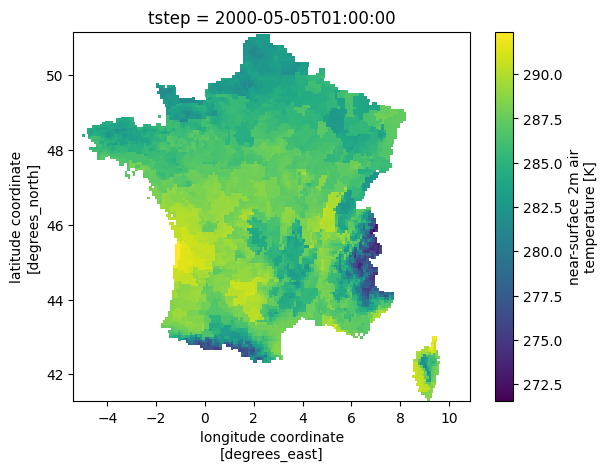

In [182]:
ds.Tair[3001].plot(x="lon", y="lat")

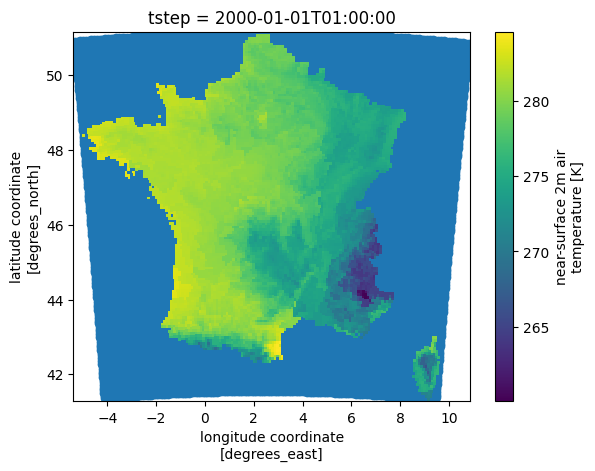

In [106]:
plt.scatter(ds.lon, ds.lat)
ds.Tair[1].plot(x="lon", y="lat")

In [214]:
display(
    ds.Tair.sel(
        tstep=timestamp,
    )
)

print(
    ds.Tair.sel(
        tstep=timestamp,
    ).sel({"lat": (lat, lon), "lon": (lat, lon)})
)

<xarray.DataArray 'Tair' (lat: 134, lon: 143)>
[19162 values with dtype=float32]
Coordinates:
    lat      (lat, lon) float32 41.36 41.37 41.37 41.38 ... 50.85 50.84 50.83
    lon      (lat, lon) float32 -4.096 -4.001 -3.907 ... 10.57 10.68 10.79
    tstep    datetime64[ns] 2000-01-01
Attributes:
    units:          K
    long_name:      near-surface 2m air temperature
    standard_name:  air_temperature
    original_name:  Tair
    grid_mapping:   Lambert_conformal
    actual_range:   [252.58645014 312.16470133]
    valid_range:    [200. 350.]

KeyError: "no index found for coordinate 'lat'"

In [153]:
# ds.lat.values[133]
display(ds.lon)
display(ds.lat)

<xarray.DataArray 'lon' (lat: 134, lon: 143)>
array([[-4.096323, -4.001427, -3.906512, ...,  9.244974,  9.339753,  9.434512],
       [-4.104116, -4.009107, -3.914078, ...,  9.253336,  9.348229,  9.443101],
       [-4.111929, -4.016805, -3.921662, ...,  9.261719,  9.356726,  9.451712],
       ...,
       [-5.30752 , -5.194962, -5.082373, ..., 10.544289, 10.656651, 10.768981],
       [-5.318517, -5.205799, -5.09305 , ..., 10.556083, 10.668605, 10.781093],
       [-5.329545, -5.216667, -5.103757, ..., 10.567911, 10.680593, 10.79324 ]],
      dtype=float32)
Coordinates:
    lat      (lat, lon) float32 41.36 41.37 41.37 41.38 ... 50.85 50.84 50.83
    lon      (lat, lon) float32 -4.096 -4.001 -3.907 ... 10.57 10.68 10.79
Attributes:
    units:          degrees_east
    long_name:      longitude coordinate
    standard_name:  longitude

<xarray.DataArray 'lat' (lat: 134, lon: 143)>
array([[41.361412, 41.367233, 41.372967, ..., 41.33101 , 41.324673, 41.31825 ],
       [41.432903, 41.438732, 41.444473, ..., 41.402462, 41.396114, 41.389683],
       [41.504402, 41.51024 , 41.515987, ..., 41.47392 , 41.467564, 41.461124],
       ...,
       [50.74244 , 50.749355, 50.75617 , ..., 50.70632 , 50.69879 , 50.691162],
       [50.813847, 50.82077 , 50.827595, ..., 50.77768 , 50.77014 , 50.7625  ],
       [50.885242, 50.892178, 50.89901 , ..., 50.84903 , 50.84148 , 50.833828]],
      dtype=float32)
Coordinates:
    lat      (lat, lon) float32 41.36 41.37 41.37 41.38 ... 50.85 50.84 50.83
    lon      (lat, lon) float32 -4.096 -4.001 -3.907 ... 10.57 10.68 10.79
Attributes:
    units:          degrees_north
    long_name:      latitude coordinate
    standard_name:  latitude

In [142]:
# Get the unique latitudes and longitudes
latitudes = ds.lat.values.flatten()
longitudes = ds.lon.values.flatten()

# Print the latitudes and longitudes
print("Latitudes:", latitudes.shape)
print("Longitudes:", longitudes.shape)

# Show duplicates in latitudes
print("Duplicate latitudes:", np.unique(latitudes).size)
print("Duplicate longitudes:", np.unique(longitudes).size)

Latitudes: (19162,)
Longitudes: (19162,)
Duplicate latitudes: 10050
Duplicate longitudes: 19162


In [191]:
# I want to find the value at a certain lat/lon point.
lat = 48.337505
lon = -2.842824
timestamp = ds.tstep.values[0]

# First, find the index of the grid point nearest a specific lat/lon.
abslat = np.abs(ds.lat - lat)
abslon = np.abs(ds.lon - lon)
# c = np.maximum(abslon, abslat)
c = np.maximum(abslat, abslon)

([yloc], [xloc]) = np.where(c == np.min(c))

print(([yloc], [xloc]))
# Now I can use that index location to get the values at the x/y diminsion
ds["Tair"].sel(tstep=timestamp, lat=1, lon=1, method="nearest")

([96], [20])


KeyError: "no index found for coordinate 'lat'"

In [71]:
# Stack the 'lat' and 'lon' dimensions into a single dimension
# ds_stacked = ds.stack(point=("lat", "lon"))

# Select the variable 'Tair' at the nearest point to the given location
tair_at_location = ds["Tair"].sel(lat=(lat, lon), lon=(lat, lon), method="nearest")

# Print the selected data
print(tair_at_location)

KeyError: "no index found for coordinate 'lat'"

In [190]:
timestamp = ds.tstep.values[1]
print(timestamp)

ds["Qair"].sel(
    tstep=timestamp,
    lat=(latitudes[1], longitudes[1]),
    lon=(latitudes[1], longitudes[1]),
    method="nearest",
)
# ds["Qair"].sel({"lat": latitudes}, method="nearest")

2000-01-01T01:00:00.000000000


KeyError: "no index found for coordinate 'lat'"

In [61]:
import pandas as pd
import xarray as xr


def extract_netcdf_values(latitudes, longitudes, netcdf_file_path):
    # Open the netCDF file
    ds = xr.open_dataset(netcdf_file_path)

    # Create a DataFrame to store the extracted values
    extracted_data = pd.DataFrame(
        columns=["Latitude", "Longitude", "Date", "Variable", "Value"]
    )

    # Iterate through each timestamp, location, and variable
    for timestamp in ds.tstep.values:
        for lat, lon in zip(latitudes, longitudes):
            for variable in ds.data_vars:
                # Extract the value from the netCDF file
                value = (
                    ds[variable]
                    .sel(lat=lat, lon=lon, tstep=timestamp, method="nearest")
                    .values.item()
                )

                # Append the information to the DataFrame
                extracted_data = extracted_data.append(
                    {
                        "Latitude": lat,
                        "Longitude": lon,
                        "Date": pd.to_datetime(str(timestamp)),
                        "Variable": variable,
                        "Value": value,
                    },
                    ignore_index=True,
                )

    # Close the netCDF file
    ds.close()

    return extracted_data


# Call the function
result = extract_netcdf_values([40, 41], [-75, -74], ffolder[0])

KeyError: "no index found for coordinate 'lat'"

In [33]:
extract_netcdf_values(lat, lon, ffolder[0])

AttributeError: 'Dataset' object has no attribute 'time'

In [ ]:
def extract_netcdf_values(latitudes, longitudes, netcdf_file_path):
    # Open the netCDF file
    ds = xr.open_dataset(netcdf_file_path)

    # Create a DataFrame to store the extracted values
    extracted_data = pd.DataFrame(columns=["Latitude", "Longitude", "Date", "Value"])

    # Iterate through each timestamp and location
    for timestamp in ds.time.values:
        for lat, lon in zip(latitudes, longitudes):
            # Extract the value from the netCDF file
            value = ds.sel(
                time=timestamp, latitude=lat, longitude=lon, method="nearest"
            ).values.item()

            # Append the information to the DataFrame
            extracted_data = extracted_data.append(
                {
                    "Latitude": lat,
                    "Longitude": lon,
                    "Date": pd.to_datetime(timestamp),
                    "Value": value,
                },
                ignore_index=True,
            )

    # Close the netCDF file
    ds.close()

    return extracted_data

In [26]:
ds = nc.Dataset(ffolder[0])
print(ds)
ds["Qair"][:]

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    history: Sat Sep 10 23:33:30 2022: ncks -v tstep Timestep_Bissextile.nc -A ORCHIDEE_France-8km-1hour_2000_fromSAFRAN.nc
Sat Sep 10 23:26:21 2022: ncks -v PSurf pression_provi.nc -A ORCHIDEE_France-8km-1hour_2000_fromSAFRAN.nc
Sat Sep 10 23:19:59 2022: ncks -v LWdown LWdown2000.nc -A ORCHIDEE_France-8km-1hour_2000_fromSAFRAN.nc
Sat Sep 10 23:15:20 2022: ncks -v SWdown SWdown2000.nc -A ORCHIDEE_France-8km-1hour_2000_fromSAFRAN.nc
Sat Sep 10 23:10:59 2022: ncks -C -v Snowf Snowf2000.nc -A ORCHIDEE_France-8km-1hour_2000_fromSAFRAN.nc
Sat Sep 10 23:06:04 2022: ncks -C -v Rainf Rainf2000.nc -A ORCHIDEE_France-8km-1hour_2000_fromSAFRAN.nc
Sat Sep 10 23:03:14 2022: ncks -v Wind Wind2000.nc -A ORCHIDEE_France-8km-1hour_2000_fromSAFRAN.nc
Sat Sep 10 23:01:35 2022: ncks -v Tair Tair2000.nc -A ORCHIDEE_France-8km-1hour_2000_fromSAFRAN.nc
Sat Sep 10 23:00:20 2022: ncks -v Qair,lon,lat Qair2000.nc -A

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., 0.0029321578331291676, --, --],
         [--, --, --, ..., 0.002955825999379158, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., 0.0029015401378273964, --, --],
         [--, --, --, ..., 0.0029292802792042494, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., 0.0028711280319839716, --, --],
         [--, --, --, ..., 0.0029027629643678665, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        ...,

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., 0.004590315278619528, --

# Load and Transform Coordinates


In [ ]:
# Load latest coordinates for nfi sites
site_coordinates = pd.read_csv("../00_process_nfi_data/nfi_final_sites_with_idp.csv")

# Get subset of sites if desired
if subset_of_coors:
    site_coordinates = site_coordinates.sample(1000, random_state=42)

# Get a random set of sites to highlight
random_sites = site_coordinates.sample(9, random_state=42)["idp"]

# Turn into geodataframe and set crs to 3035
df_sites_org = site_coordinates.copy()[["idp", "first_year", "x_fr", "y_fr"]]
df_sites_org = gpd.GeoDataFrame(
    df_sites_org,
    geometry=gpd.points_from_xy(df_sites_org.x_fr, df_sites_org.y_fr),
    crs="EPSG:4326",
)

# From geodataframe, extract x and y locations
x_filecrs = df_sites_filecrs.geometry.x
y_filecrs = df_sites_filecrs.geometry.y

# Overwrite df_sites again and attach filecrs-based coordinates
df_sites = site_coordinates.copy()[["idp", "first_year"]]
df_sites["x"] = x_filecrs
df_sites["y"] = y_filecrs

# Attach start and end year for each site for easier extraction
df_sites["start_year"] = df_sites.first_year - 5
df_sites["end_year"] = df_sites.first_year + 5

# Print info
print(df_sites.shape)
df_sites.head(3)

(40022, 6)


,idp,first_year,x,y,start_year,end_year
0,632691,2011,-2.842824,48.337505,2006,2016
1,702597,2012,3.349757,46.198025,2007,2017
2,706240,2012,3.361577,46.827747,2007,2017


In [ ]:
# Create folium map to see if nfi_plots still fall within France
# Get subset to not plot all 40k sites, if not reduced already
if subset_of_coors:
    df_map1 = df_sites_org
    df_map2 = df_sites_filecrs
else:
    df_map1 = df_sites_org.sample(random_state=42, n=1000)
    df_map2 = df_sites_filecrs.sample(random_state=42, n=1000)

# Dataframe to highlight a specific site
df_highlight = df_sites_org.query("idp in @random_sites")

# Make map
m = folium.Map(location=[46.5, 2], zoom_start=6)

# Add original sites to map
folium.GeoJson(
    df_map1,
    name="Original NFI Sites",
    tooltip=folium.features.GeoJsonTooltip(
        fields=["idp"], aliases=["NFI Plot"], localize=True
    ),
    marker=folium.CircleMarker(fill=True, color="black"),
).add_to(m)

# Add transformed sites to map
folium.GeoJson(
    df_map2,
    name="Transformed NFI Sites",
    tooltip=folium.features.GeoJsonTooltip(
        fields=["idp"], aliases=["NFI Plot"], localize=True
    ),
    marker=folium.CircleMarker(fill=True, color="red", radius=1),
).add_to(m)

# Add highlighted sites to map
folium.GeoJson(
    df_highlight,
    name="Highlighted NFI Sites",
    tooltip=folium.features.GeoJsonTooltip(
        fields=["idp"], aliases=["NFI Plot"], localize=True
    ),
    marker=folium.CircleMarker(fill=True, color="blue", radius=5),
).add_to(m)

# Add layer control
folium.LayerControl(collapsed=False).add_to(m)

# Save map
if subset_of_coors:
    m.save(
        f"edo_qc_files/{subfolder}_map_to_check_transformation_and_randomsites_subset.html"
    )
else:
    m.save(f"edo_qc_files/{subfolder}_map_to_check_transformation_and_randomsites.html")

# Show map
m

# Load all years for all files into one dataframe


In [ ]:
# Run in parallel
df_mp = run_mp(
    parallel_edo_extraction,
    df_list,
    progress_bar=True,
    num_cores=10,
    df_sites=df_sites,
    debug=False,
    expected_crs=file_crs,
)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [30:40<00:00, 184.03s/it]  


In [ ]:
# Unlist results by concatenating them
df_unlisted = pd.concat(df_mp)

# Clean structure a bit
df_unlisted = df_unlisted.sort_values(["idp", "date"]).reset_index(drop=True)
df_unlisted.insert(0, "idp", df_unlisted.pop("idp"))
df_unlisted.insert(1, "date", df_unlisted.pop("date"))

# Set -9999 to NA
df_unlisted = df_unlisted.replace(-9999, np.nan)

# Attach season information
df_unlisted = match_season_to_month(df_unlisted)

# Attach information whether observation is from before or after first_year
# * Important Assumption: Measurement was done on 31st of August (fall-cut-off)
# Code looks ugly but works
df_unlisted["before_first_year"] = df_unlisted["date"] < (
    df_unlisted["first_year"].astype(str) + "-08-31"
).astype("datetime64[ns]")

# Display it
display(df_unlisted)

,idp,date,mintmp,first_year,x,y,start_year,end_year,season,before_first_year
0,500002,2005-01-01,3.3025,2010,7.378014,48.253411,2005,2015,winter,True
18675033,562918,2005-01-01,3.1995,2010,5.837938,47.805254,2005,2015,winter,True
18671016,562899,2005-01-01,10.7595,2010,-1.980153,47.705838,2005,2015,winter,True
2068755,506900,2005-01-01,5.2200,2010,1.574573,48.988112,2005,2015,winter,True
18666999,562896,2005-01-01,9.2980,2010,0.788900,46.947840,2005,2015,winter,True
...,...,...,...,...,...,...,...,...,...,...
151688025,1117717,2021-12-31,4.5650,2016,6.376465,46.806061,2011,2021,winter,False
151692043,1117727,2021-12-31,-0.0840,2016,5.637757,44.380744,2011,2021,winter,False
151696061,1117750,2021-12-31,5.3890,2016,0.607629,46.864264,2011,2021,winter,False
151704097,1117767,2021-12-31,6.9090,2016,-0.884106,45.913565,2011,2021,winter,False


# Quality Control of Extraction


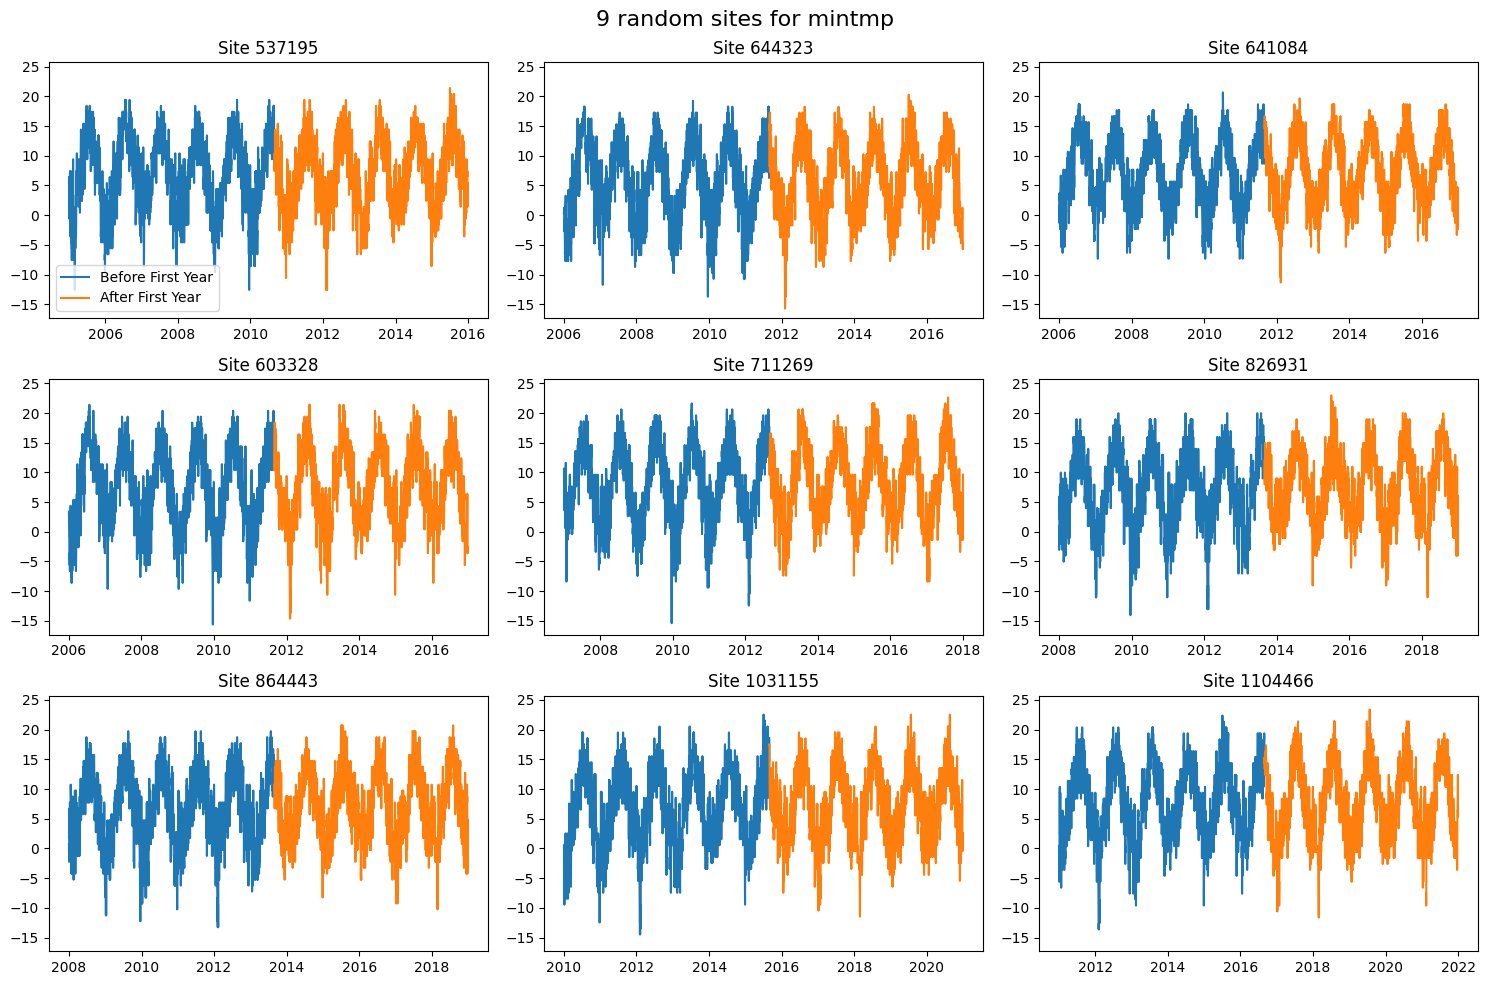

In [ ]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Add a title to the entire grid
fig.suptitle(f"{len(axes.flatten())} random sites for {subfolder}", fontsize=16)

# Reduce df_unlisted to sites in random_sites
df_red = df_unlisted.query("idp in @random_sites").copy().reset_index(drop=True)

# If heatwave dataset, replace NA by 0 to make plot more readable
if subfolder == "heatw":
    df_red[subfolder] = df_red[subfolder].fillna(0)

# Get minimum and maximum value for y-axis
min_ = df_red[subfolder].min()
max_ = df_red[subfolder].max()

# Iterate over each subplot
for i, ax in enumerate(axes.flatten()):
    # Reduce df_unlisted to sites in random_sites
    random_site = df_red["idp"].unique()[i]

    # Get subset
    subset = df_red[df_red["idp"] == random_site]

    # Plot subset when before_first_year is true
    ax.plot(
        subset[subset["before_first_year"]]["date"],
        subset[subset["before_first_year"]][subfolder],
        label="Before First Year",
    )

    # Plot subset when before_first_year is false
    ax.plot(
        subset[~subset["before_first_year"]]["date"],
        subset[~subset["before_first_year"]][subfolder],
        label="After First Year",
    )

    ax.set_title(f"Site {random_site}")

    # Set y-axis limits
    ax.set_ylim((min_ + min_ * 0.1), (max_ + max_ * 0.1))

# Add legend to the last subplot
axes.flatten()[0].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Save the plot
if subset_of_coors:
    plotname = f"edo_qc_files/{subfolder}_random_sites_subset.png"
else:
    plotname = f"edo_qc_files/{subfolder}_random_sites.png"
plt.savefig(plotname)

# Show the plot
plt.show()

# Save File


In [ ]:
# Save pre-aggregation dataframe
if subset_of_coors:
    savedfeather = f"data_edo_{subfolder}_raw_subset.feather"
else:
    savedfeather = f"data_edo_{subfolder}_raw.feather"

df_unlisted.reset_index(drop=True).to_feather(savedfeather)

print(f"✅ Successfully saved dataframe:\t{savedfeather}\t at {datetime.datetime.now()}")
chime.success()

✅ Successfully saved dataframe:	data_edo_mintmp_raw.feather	 at 2023-12-11 19:29:29.935969
